# Undersampling

In [1]:
import pandas as pd
import numpy as np
import collections
import time

In [17]:
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [3]:
data = pd.read_csv('creditcard.csv')

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
from sklearn.preprocessing import StandardScaler

amount_after_scaling = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)
data.insert(0, 'Amount_after_scaling', amount_after_scaling)


In [6]:
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X,y,test_size=0.20,random_state=42)
y_data_test_non_fraud_num = y_data_test.value_counts()[0]
y_data_test_fraud_num = y_data_test.value_counts()[1]

In [7]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
X_usample_train, y_usample_train = undersample.fit_resample(X_data_train, y_data_train)
y_usample_non_fraud_num = y_usample_train.value_counts()[0]
y_usample_fraud_num = y_usample_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_fraud_num + y_usample_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon undersamplinga: 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga: 394
Ukupan broj transakcija u trening skupu nakon undersamplinga: 788


In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

In [9]:
%run functions.ipynb

## Logistička regresija

In [34]:
from sklearn.model_selection import cross_val_score
usample_log_reg = LogisticRegression(solver='liblinear')
usample_log_reg.fit(X_usample_train, y_usample_train)

usample_log_reg_training_score = cross_val_score(usample_log_reg, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: ' 
     + str(round(usample_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: 93.4%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.6000000000000005%
	Recall score: 91.84%
	F1 score: 10.56%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


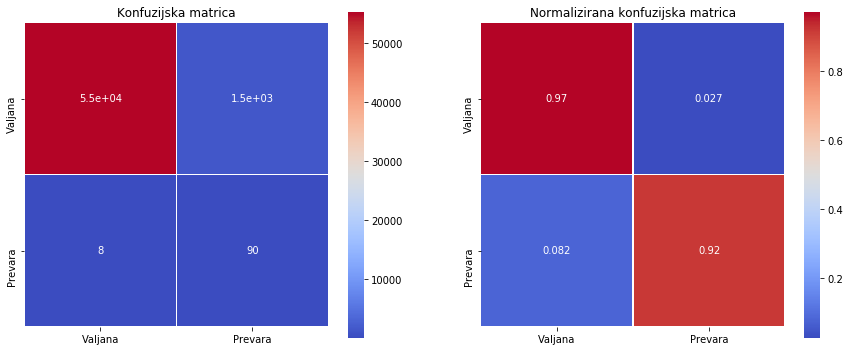

----------------------------------------------------------------------------------------------------


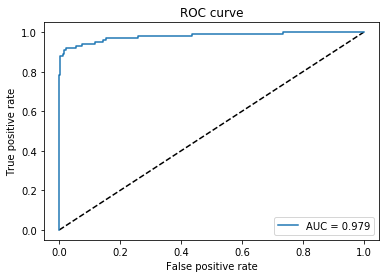

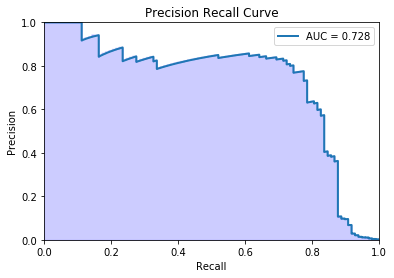

In [35]:
full_pred_log_reg = usample_log_reg.predict(X_data_test)
full_pred_score_log_reg = usample_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg, True)

Vidimo da smo s logističkom regresijom kao klasifikatorom dobili sljedeće rezultate. Preciznost (5.60%) i f1-mjera(10.56%) nisu najbolji rezultati. No cilj nam je točno klasificirati što više prevara, a ovaj model ih je točno klasificirao 90 prevara (od ukupno 98). Stoga je i osjetljivost dosta visoka (91.84%). Iz konfuzijske matrice možemo očitati i koji je razlog toga što su preciznost i f1-mjera dosta slabi, a to jest ~1500 transakcija koje su valjane, a model ih je klasificirao kao prevare. Također vidimo da je i površina ispod PR-krivulje 0.728. <br> Sada ćemo pokušati podesiti parametre i vidjeti kako će to utjecati na rezultate.

Parametri koje podešavamo kod linearne regresije su:
<ul>
    <li><em>C</em> - regularizacijski parametar, inverzno proporcionalan $\lambda$ regulatoru. </li>
    <li><em>penalty</em> - određuje koju regularizacijsku tehniku koristimo
        <ul>
            <li><i>ridge (l2)</i> - kazna je "kvadratna veličina" koeficjenata
                \[
                rCost = \sum_{i = 1}^{n}\bigg(y_i - \sum_{j=1}^{p}x_{ij}\beta_j \bigg)^2  + \lambda \sum_{j=1}^{p} \beta_j^2
                \]</li>
            <li><i>lasso (l1)</i> - kazna je "apsolutna vrijednost veličine" koeficjenata 
            \[
            lCost = \sum_{i = 1}^{n}\bigg(y_i - \sum_{j=1}^{p}x_{ij}\beta_j \bigg)^2  + \lambda \sum_{j=1}^{p} \mid\beta_j\mid
            \]</li>
        </ul>
    </li>
</ul>

In [36]:
from sklearn.model_selection import GridSearchCV
log_reg_c_params = [0.01, 0.1, 1, 10, 100]
log_reg_penalties = ['l1','l2']
log_reg_params = {"penalty": log_reg_penalties, 'C': log_reg_c_params}

In [37]:
grid_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg.fit(X_usample_train, y_usample_train)
log_reg_params_usample = grid_log_reg.best_estimator_
log_reg_params = grid_log_reg.best_params_
print('Najbolji parametri: ' + str(log_reg_params))

log_reg_training_score_params_usample = cross_val_score(log_reg_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.1, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): 93.49%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.0600000000000005%
	Recall score: 90.82000000000001%
	F1 score: 11.37%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


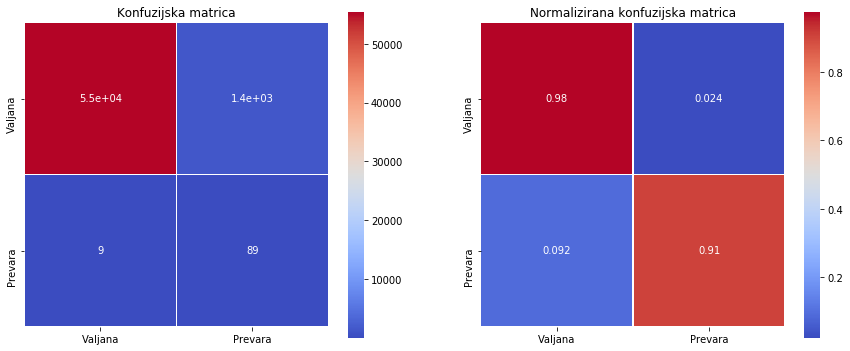

----------------------------------------------------------------------------------------------------


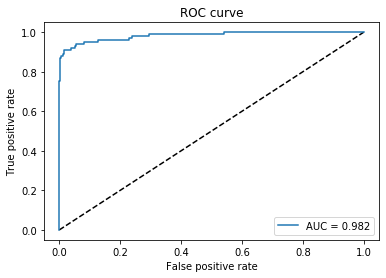

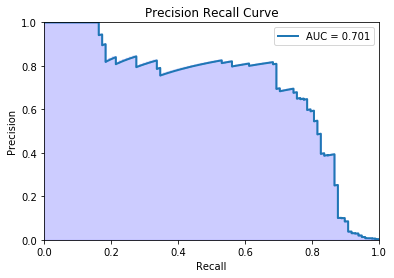

In [38]:
full_pred_log_reg_params = log_reg_params_usample.predict(X_data_test)
full_pred_score_log_reg_params = log_reg_params_usample.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params, True)

Vidimo da smo podešavanjem parametara dobili dosta bolje rezultate. I preciznost (6.06%) i f1-mjera (11.37%) su porasle, dok je osjetljivost pala na 90.82%. Kada usporedimo konfuzijsku matricu s prošlom vidjet ćemo i zašto. Novi model je pogrešno klasificirao ~1400 valjanih transakcija (prošli je imao ~1500). To znači da će ljudima koji će 'ručno' provjeravati te transakcije uštedjeti dosta posla (oko 100 transakcija), ali je zato i ispravno klasificirao 89 prevara (bilo je 90). Površina ispod PR-krivulje je nešto manja nego kod prošlog modela, ali to nije značajna razlika. <br> Još ćemo pokušati u klasifikator ubaciti težine klasa. Težinama omogućavamo klasifikatoru da bude pristraniji prema nekoj klasi.

****************************************************************************************************
Tezina klase 1 (prevare) je 0.1 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 37.269999999999996%
	Recall score: 83.67%
	F1 score: 51.57000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.84      0.52        98

    accuracy                           1.00     56962
   macro avg       0.69      0.92      0.76     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


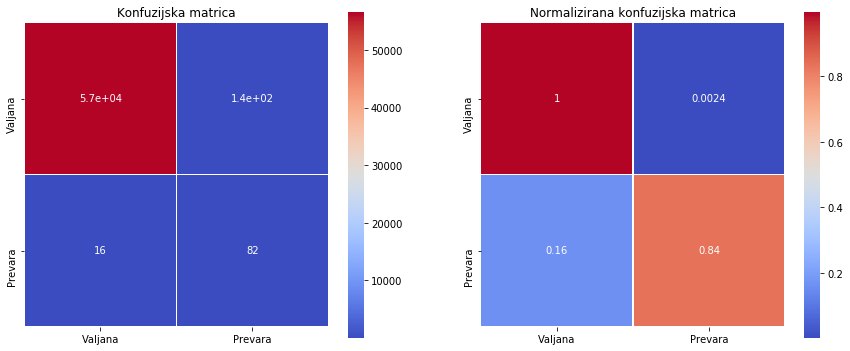

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.2 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 25.22%
	Recall score: 86.72999999999999%
	F1 score: 39.08%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.87      0.39        98

    accuracy                           1.00     56962
   macro avg       0.63      0.93      0.69     56962
weighted avg       1.00      1.00      1.00     56962


------------------------------------------------------------------------------------------------

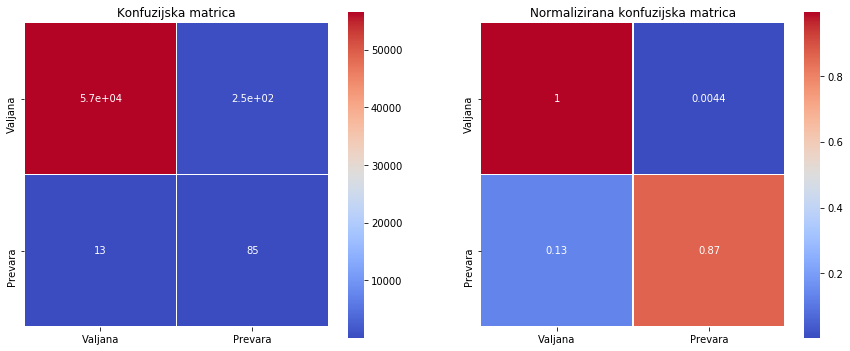

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.5 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.81%
	Recall score: 87.76%
	F1 score: 17.64%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.88      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.58     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


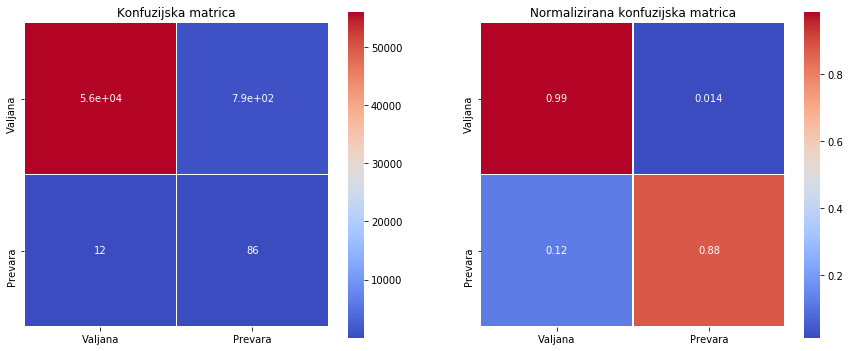

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.7 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.27%
	Recall score: 89.8%
	F1 score: 15.15%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


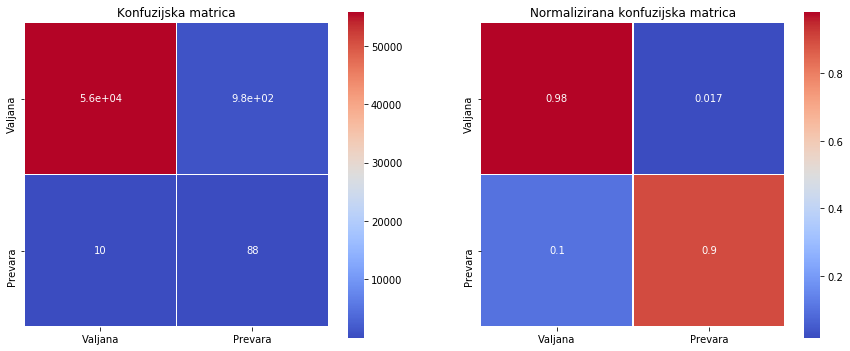

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 1 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.0600000000000005%
	Recall score: 90.82000000000001%
	F1 score: 11.37%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962


-------------------------------------------------------------------------------------

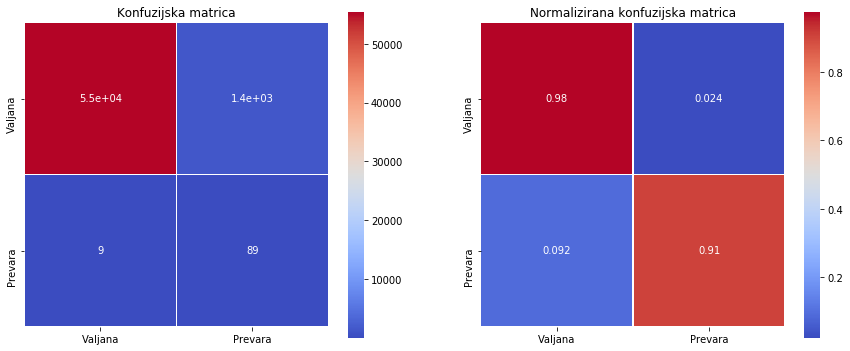

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 2 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.1399999999999997%
	Recall score: 91.84%
	F1 score: 6.069999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962


-------------------------------------------------------------------------------------

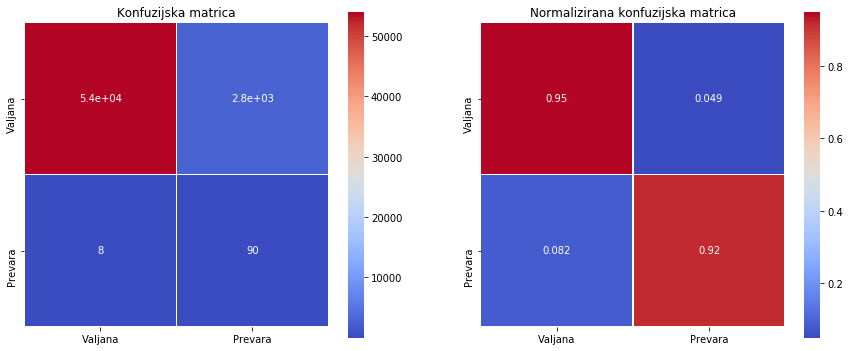

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 5 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.3299999999999998%
	Recall score: 95.92%
	F1 score: 2.6100000000000003%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     56864
           1       0.01      0.96      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.92      0.48     56962
weighted avg       1.00      0.88      0.93     56962


------------------------------------------------------------------------------------

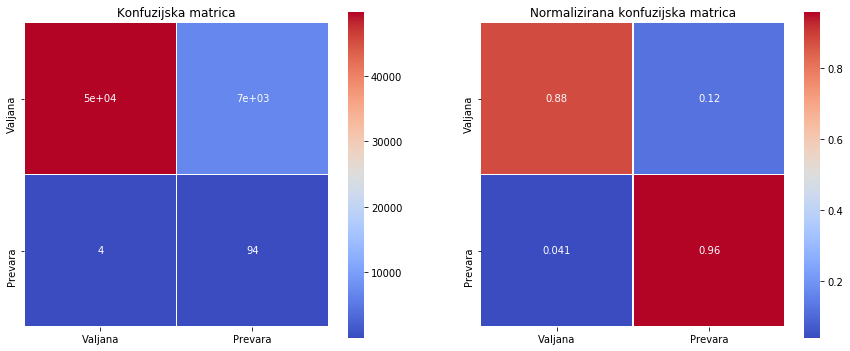

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 10 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.77%
	Recall score: 95.92%
	F1 score: 1.53%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     56864
           1       0.01      0.96      0.02        98

    accuracy                           0.79     56962
   macro avg       0.50      0.87      0.45     56962
weighted avg       1.00      0.79      0.88     56962


----------------------------------------------------------------------------------------------------


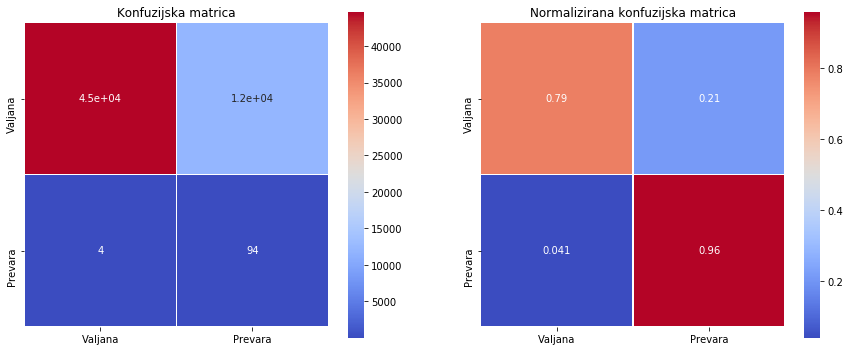

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 50 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.36%
	Recall score: 96.94%
	F1 score: 0.7100000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.53      0.70     56864
           1       0.00      0.97      0.01        98

    accuracy                           0.53     56962
   macro avg       0.50      0.75      0.35     56962
weighted avg       1.00      0.53      0.69     56962


-------------------------------------------------------------------------------------------------

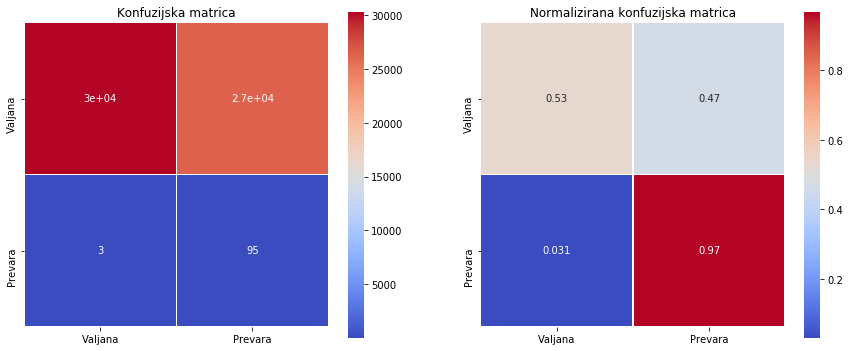

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 100 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.31%
	Recall score: 97.96000000000001%
	F1 score: 0.62%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.46      0.63     56864
           1       0.00      0.98      0.01        98

    accuracy                           0.46     56962
   macro avg       0.50      0.72      0.32     56962
weighted avg       1.00      0.46      0.63     56962


--------------------------------------------------------------------------------------------------

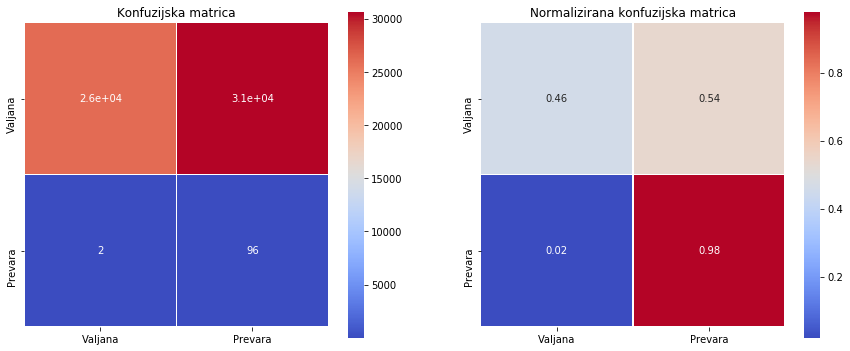

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 1000 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.26%
	Recall score: 98.98%
	F1 score: 0.51%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.34      0.51     56864
           1       0.00      0.99      0.01        98

    accuracy                           0.34     56962
   macro avg       0.50      0.66      0.26     56962
weighted avg       1.00      0.34      0.50     56962


----------------------------------------------------------------------------------------------------


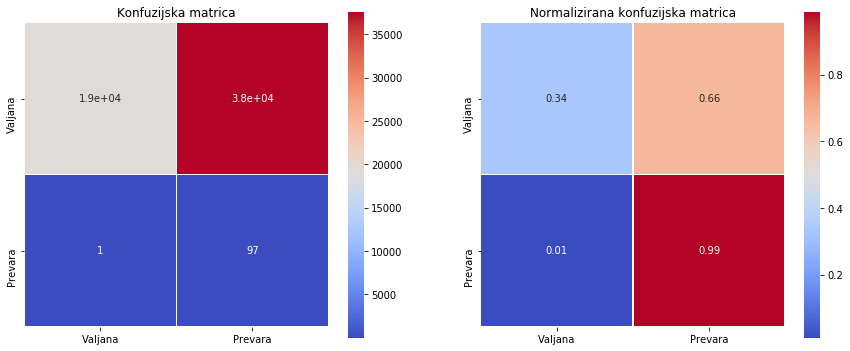

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 10000 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.19%
	Recall score: 100.0%
	F1 score: 0.38999999999999996%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.12      0.21     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.12     56962
   macro avg       0.50      0.56      0.11     56962
weighted avg       1.00      0.12      0.21     56962


---------------------------------------------------------------------------------------------

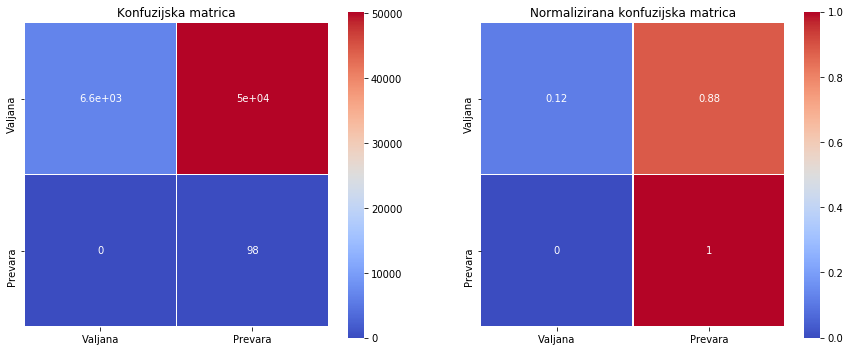

----------------------------------------------------------------------------------------------------


In [39]:

class_weights = [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 10, 50, 100, 1000, 10000]
colors = ['blue', 'yellow', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'gold', 'lime', 'grey', 'black']
i = 0
precisions = []
recalls = []
fprs = []
tprs = []
aucs = []
aprcs = []


for weight in class_weights: 
    log_reg_weighted = LogisticRegression(C=log_reg_params['C'], 
                                          penalty=log_reg_params['penalty'],
                                          solver='liblinear', class_weight={0:1, 1:weight}
                                         )
    
    log_reg_weighted.fit(X_usample_train, y_usample_train)

    full_pred_w = log_reg_weighted.predict(X_data_test)
    full_score_w = log_reg_weighted.decision_function(X_data_test)
    print('*'*100)
    print('Tezina klase 1 (prevare) je ' + str(weight) + ' puta veća od klase 0 (valjane).' )
    print_everything(y_data_test, full_pred_w, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_w, False)
    
    precision, recall, threshold = precision_recall_curve(y_data_test, full_score_w)
    fpr, tpr, thold = roc_curve(y_data_test, full_score_w)
    area_under_curve = auc(fpr,tpr)
    au_pr_curve = auc(recall,precision)
    
    precisions.append(precision)
    recalls.append(recall)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(area_under_curve)
    aprcs.append(au_pr_curve)

Vidimo da kada podesimo težine dobijemo dosta drugačije rezultate (dosta veća preciznost i f1-mjera). Kada stavimo da je težina valjane klase vidimo da se kod modela drastično smanji broj pogrešno klasificiranih valjanih transakcija. Primjerice, kada je težine valjane klase 10 puta veća od klase prevara dobijemo svega 140 pogrešno klasificirane valjane transakcije (bez težina je bilo ~1400), što je značajan napredak. No, time smo i izgubili na broju ispravno klasificiranih prevara (sada ih je samo 82). Odnosno, 8 ljudi više nego prije će se 'izvuć' bez posljedica iako su nekom ukrali novac. <br> Isto tako kada je težina klase prevara 10 puta veća od klase valjana tada imamo jako nisku preciznost i f1-mjeru, ali je osjetljivost jako visoka (95.92%). Odnosno, sa takvim težinama model ispravno klasificira ispravno čak 94 prevar3. Doduše, isti model klasificira ~12000 valjanih transakcija kao prevare. <br> Od svih tih modela možemo odbrati onaj koji nam najviše odgovara (moežemo i detaljnije podesiti težine).

C:\Users\stvar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


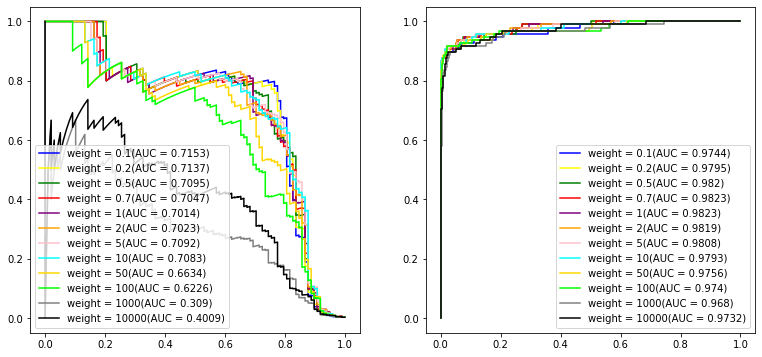

In [40]:
fig_w, ax_w = plt.subplots(1,2,figsize=(13,6))

for i in range(len(colors)):
    ax_w[0].plot(recalls[i], precisions[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aprcs[i], 4)) + ')')
    ax_w[1].plot(fprs[i], tprs[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aucs[i], 4)) + ')' )
ax_w[0].legend()
ax_w[1].legend()
plt.show()


Na slikama iznad vidimo i kako težine utječu na PR-krivulju (lijevo) i ROC-krivulju (desno).

## Stabla odluke

In [41]:
dt_usample = DecisionTreeClassifier()
dt_usample.fit(X_usample_train, y_usample_train)
dt_training_score_usample = cross_val_score(dt_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za stabla odluke nad undersampliranim datasetom: " + 
      str(round(dt_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za stabla odluke nad undersampliranim datasetom: 88.11%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.02%
	Recall score: 91.84%
	F1 score: 3.9600000000000004%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.92      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.92      0.50     56962
weighted avg       1.00      0.92      0.96     56962


----------------------------------------------------------------------------------------------------


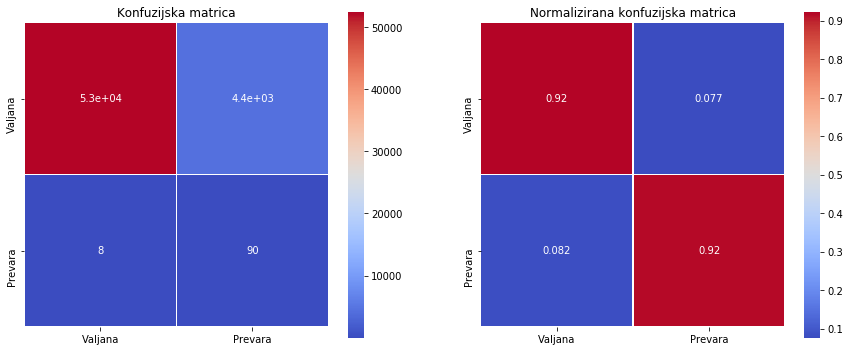

----------------------------------------------------------------------------------------------------


In [42]:
full_pred_dt = dt_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_dt, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Prvo što primjećujemo kod ovog modela je da su rezultati dosta slabiji. Vidimo da su preciznost (2.02%) i f1-mjera (3.96%) dosta manji nego kod logističke regresije. Ono što ovaj model čini dosta lošijim je što je uz to i osjetljivost slabija (91.84%). Kod matrice konfuzije prvo uočavamo da je pogrešno klasificirano čak ~4400 valjanih transakcija. Što je i više nego dvostruko koliko je model temeljen na logističkoj regresiji (bez parametara je bilo ~1500). Primjetimo i da ovaj model ima 90 ispravno klasificiranih prevara (kod logističke regresije je također bilo 90). <br> Pokušat ćemo i za ovaj model podesiti parametre pa vidjeti hoćemo li tako dobiti bolji model. 

Parametri koje podešavamo kod stabala odluke:
<ul>
    <li><em>kriterij</em> - funkcija kvalitete podjele
        <ul>
            <li><i>gini</i> - kriterij koji koristimo da smanjimo vjerojatnost pogrešne klasifikacije
            \[
            Gini = 1 - \sum_j p_j^2
            \]</li>
            <li><i>entropy</i> - kriterij koji koristimo da smanjimo nečistoću podjele
            \[
            Entropy = - \sum_j p_j log_2p_j
            \]</li>
        </ul>
    </li>
</ul>

In [43]:
criterion_params = ['gini', 'entropy']
splitter_params = ['best', 'random']
max_depth_params = [1, 2, 3, 4, 5, 6, 7]
min_samples_leaf_params = [1, 3, 5, 7]
dt_params = {'criterion': criterion_params, 'splitter': splitter_params, 'max_depth': max_depth_params, 'min_samples_leaf': min_samples_leaf_params}
grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt.fit(X_usample_train, y_usample_train)
dt_params_usample = grid_dt.best_estimator_
dt_params_best = grid_dt.best_params_
print('Najbolji parametri: ' + str(dt_params_best))

dt_training_score_params_usample = cross_val_score(dt_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(dt_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'splitter': 'random'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): 91.2%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.83%
	Recall score: 90.82000000000001%
	F1 score: 3.58%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.91      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.92      0.95     56962


----------------------------------------------------------------------------------------------------


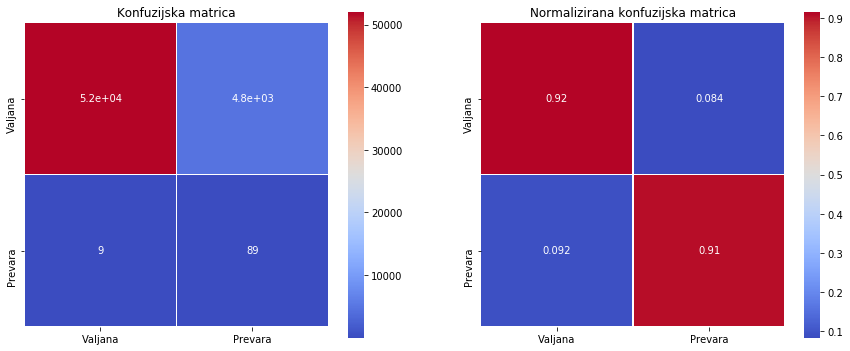

----------------------------------------------------------------------------------------------------


In [44]:
full_pred_dt_params = dt_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_dt_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Vidimo da smo ovdje dobili slabiji model. Preciznije, smanjili smo preciznost (1.83%) i f1-mjeru (3.58%), ali i osjetljivost (90.82%). Pomoću konfuzijske matrice vidimo da smo dobili ~4800 pogrešno klasificiranih transakcija (imali smo ~4400). 

## Bagging

In [45]:
bag_usample = BaggingClassifier()
bag_usample.fit(X_usample_train, y_usample_train)
bag_training_score_usample = cross_val_score(bag_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za bagging nad undersampliranim datasetom: " + 
      str(round(bag_training_score_usample.mean(), 4) * 100) + '%')


Rezultat treniranja za bagging nad undersampliranim datasetom: 92.25999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.55%
	Recall score: 91.84%
	F1 score: 10.47%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


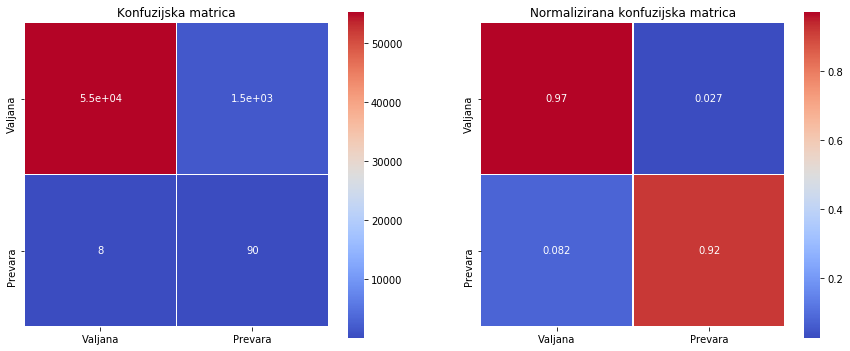

----------------------------------------------------------------------------------------------------


In [46]:
full_pred_bag = bag_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_bag, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem bagginga (na stablima odluke) dobijamo dosta bolji rezultat nego korištenjem običnih stabala odluke. Vidimo da je ovaj model bolji u sve tri metrike. Odnosno, preciznost ovog modela je 5.55%, f1-mjera 10.47%, a osjetljivost 91.84%. Pomoću konfuzijske matrice vidimo da imamo 90 ispravno klasificiranih prevara (jednako kao i stabla odluke), odnosno jednu više nego na stablima odluke. Također ovaj model pogrešno klasificira ~ 1500 prevara (isto kao i model  logističe regresije ), dok je model na stablima odluke pogrešno klasificirao čak ~4400 (prije podešavanja parametara).

Parametri koje podešavamo na bagging klasifikatoru na stablima odluke:
<ul>
    <li><em>broj procjenitelja</em> - određuje broj stabala odluke u ansamblu </li>
    <li><em>maksimalan udio podataka</em> - određuje udio koji 'vadimo' iz trening skupa kod treniranja svakog procjenitelja</li>
    <li><em>maksimalan udio značajki</em> - određuje udio značajki koje koristimo prilikom treniranja </li>
</ul>

In [47]:
num_estimators_params = [5, 7, 10, 12, 20, 50, 100]
max_samples_params = [0.5, 0.7, 0.9, 1.0]
max_features_params = [0.3, 0.5, 0.7, 0.9, 1.0]
bag_params = {'n_estimators': num_estimators_params, 'max_samples': max_samples_params,
              'max_features': max_features_params}
grid_bag = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag.fit(X_usample_train, y_usample_train)
bag_params_usample = grid_bag.best_estimator_
bag_params_best = grid_bag.best_params_
print('Najbolji parametri: ' + str(bag_params_best))

bag_training_score_params_usample = cross_val_score(bag_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(bag_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'max_features': 0.5, 'max_samples': 0.9, 'n_estimators': 50}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): 93.06%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.340000000000001%
	Recall score: 90.82000000000001%
	F1 score: 13.59%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


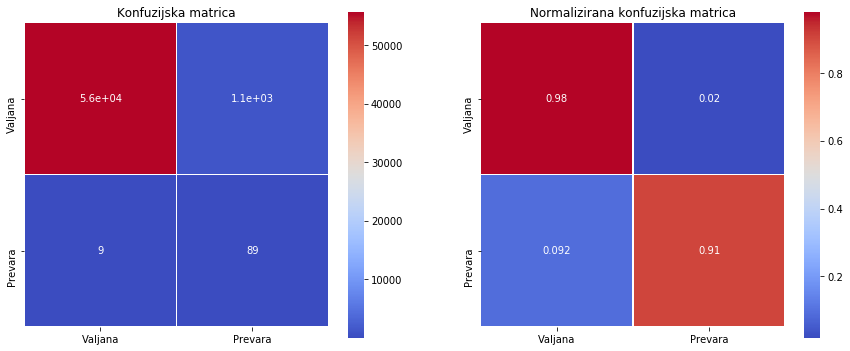

----------------------------------------------------------------------------------------------------


In [48]:
full_pred_bag_params = bag_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_bag_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Kao i u prijašnjim primjerima, podešavanje parametara je poboljšalo preciznost (7.34%) te f1-mjeru (13.59%), ali i smanjilo osjetljivost (90.82%). Preko konfuzijske matrice vidimo da je razlog tome pad u broj pogrešno klasificiranih valjanih transakcija (bilo je ~1500, sad je ~1100).

## Slučajne šume

In [49]:
rf_usample = RandomForestClassifier()
rf_usample.fit(X_usample_train, y_usample_train)
rf_training_score_usample = cross_val_score(rf_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za slučajne šume nad undersampliranim datasetom: " + 
      str(round(rf_training_score_usample.mean(), 4) * 100) + '%')


Rezultat treniranja za slučajne šume nad undersampliranim datasetom: 93.53%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.04%
	Recall score: 90.82000000000001%
	F1 score: 14.77%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


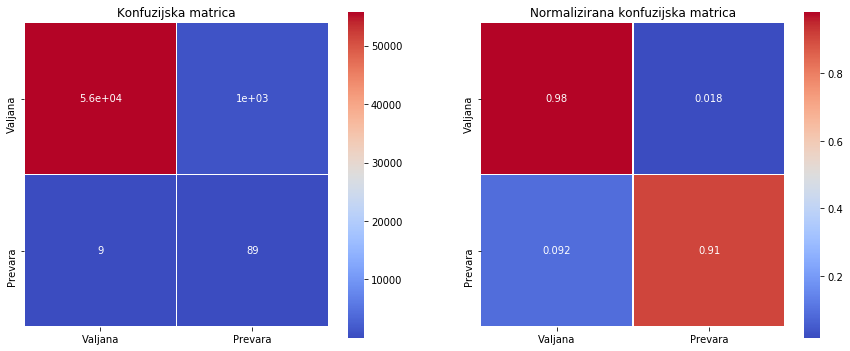

----------------------------------------------------------------------------------------------------


In [50]:
full_pred_rf = rf_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Ovaj model je dosad najbolji (bez parametara). Vidimo da ima dosad najvišu preciznost (8.04%) i f1-mjeru (14.77%), te jednaku osjetljivost (90.82%) kao i mnogi modeli prije. Preciznije, ovaj model kao i neki prethodni ima 89 ispravno klasificiranih prevara, dok ima i najmanje pogrešno klasificiranih valjanih transakcija (~1000).

Parametri koje promatramo kod slučajnih šuma:
<ul>
    <li><em>kriterij</em> - poprima vrijednosti <i>gini</i> ili <i>entropy</i> koji su isto definirani kao i kod stabala odluke</li>
    <li><em>broj procjenitelja</em> - određuje broj stabala u slučajnoj šumi</li>
    <li><em>maksimalna dubina</em> - određuje maksimalnu dubinu svakog stabla u šumi</li>
    <li><em>minimalan broj list</em> - određuje koliko primjeraka najmanje smije bit u listu stabla</li>
    <li><em>težina klasa</em> - određuje težine koje dodjeljujemo klasama prilikom klasifikacije (valjana, prevara)
        <ul>
            <li><i>balanced</i> - određuje težine tako da uzima broj pojavljivanja klasa u ulaznim podacima</li>
            <li><i>balanced_subsample</i> - isto kao i <i>balanced</i>, ali su u ovom slučaju težine bazirane na bootstrap primjerku svakog stabla koje se gradi</li>
        </ul>
    </li>
</ul>

In [51]:


criterion_params = ['gini', 'entropy']
num_estimators_params = [5, 10, 50, 100]
max_depth_params = [1, 2, 3, 4, 5, 7, 9]
min_samples_leaf_params = [1, 3, 5, 7]
class_weight_params = ['balanced', 'balanced_subsample']
rf_params = {'criterion': criterion_params, 'n_estimators': num_estimators_params, 'max_depth': max_depth_params,
             'min_samples_leaf': min_samples_leaf_params, 'class_weight': class_weight_params}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_usample_train, y_usample_train)
rf_params_usample = grid_rf.best_estimator_
rf_params_best = grid_rf.best_params_
print('Najbolji parametri: ' + str(rf_params_best))

rf_training_score_params_usample = cross_val_score(rf_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(rf_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 50}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): 93.36%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.04%
	Recall score: 90.82000000000001%
	F1 score: 14.77%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


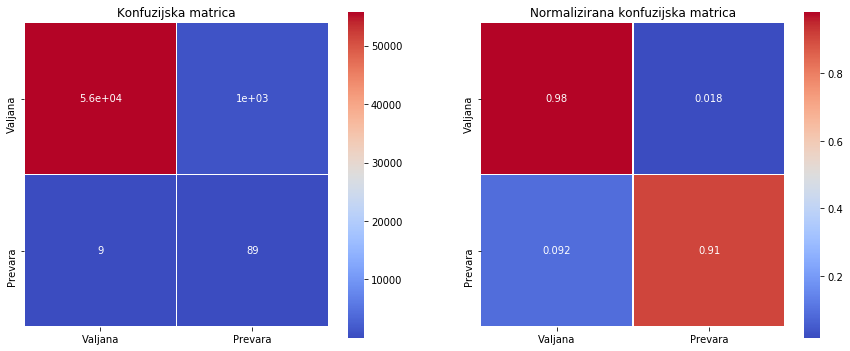

----------------------------------------------------------------------------------------------------


In [52]:
full_pred_rf = rf_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Za razliku od prethodnih modela podešavanjem parametara kod slučajnih šuma nije poboljšalo rezultate testiranja ni u jednom aspektu (niti je pogoršalo).

## Metoda najbližih susjeda

In [53]:
knn_usample = KNeighborsClassifier()
knn_usample.fit(X_usample_train, y_usample_train)
knn_training_score_usample = cross_val_score(knn_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: " + 
      str(round(knn_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: 93.15%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.02%
	Recall score: 89.8%
	F1 score: 13.020000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


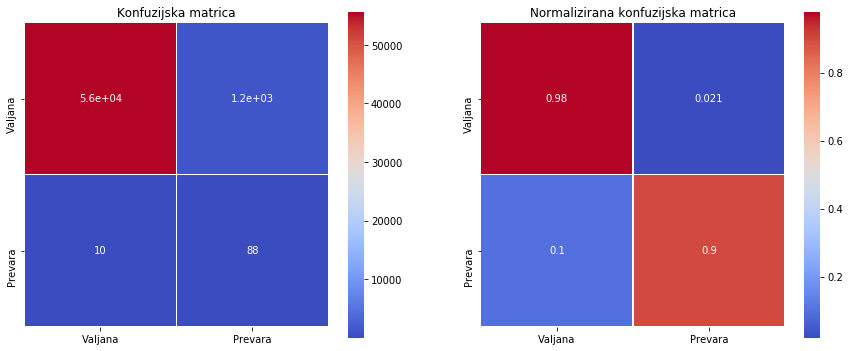

----------------------------------------------------------------------------------------------------


In [54]:
full_pred_knn = knn_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_knn, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći metodu najbližih susjeda dobili smo bolju preciznost (7.02%) i f1-mjeru (13.02%) u odnosu na većinu prethodnih klasifikatora, no također smo dobili i nešto lošiju osjetljivost (89.8%). Iz matrice konfuzije vidimo da osjetljivost nešto lošija nego kod prijašnjih klasifikatora zbog toga što je u ovom slučaju ispravno klasificirano 'samo' 88 prevara (dosad je bilo ili 89 ili 90). Doduše broj pogrešno klasificiranih valjanih transakcija je oko 1200, što je bolje od svih prethodnih klasifikatora osim slučajnih šuma. <br>
Sada ćemo podesiti parametre i vidjeti hoće li to imati ikakvog utjecaja na rezultate testiranja.

Parametri koje podešavamo kod metode najbližih susjeda:
<ul>
    <li><em>broj susjeda</em> - određuje koliko najbližih susjeda sudjeluje u 'glasanju' prilikom klasifikacije nekog primjerka</li>
    <li><em>algoritam</em> - određuje algoritam koji koristimo da bi pronašli najbliže susjede 
        <ul>
            <li><i>ball tree</i> - dijeli primjerke podataka u ugniježđene skupove hipersfera koje nazivamo loptama (balls)</li>
            <li><i>KD tree</i> - dijeli primjerke podataka u k-dimenzionalne kocke</li>
            <li><i>brute</i> - koristi dobro poznati pristup grubom silom</li>
            <li><i>auto</i> - automatski pokušava utvrditi koji je najprikladniji algoritam na temelju podataka koje prima <i>fit</i> metoda
        </ul>
    </li>
    <li><em>p (power)</em> - biramo koji algoritam koristimo da bi mjerili udaljenost
        <ul>
            <li><i>manhattan udaljenost (1)</i> - $d_1(p,q) = \sum_{i=1}^n \mid p_i - q_i \mid$</li>
            <li><i>euklidska udaljenost (2)</i> - $d_2(p,q) = \sqrt{\sum_{i=1}^n  (p_i - q_i)^2 }$</li>
        </ul>
    </li>
</ul>

In [55]:
num_neighbors_params = [1, 2, 3, 4, 5, 7, 9]
alg_params = ['auto', 'brute', 'ball_tree', 'kd_tree']
p_params = [1, 2]

knn_params = {'n_neighbors': num_neighbors_params, 'algorithm': alg_params, 'p': p_params, 'metric': ['minkowski']}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_usample_train, y_usample_train)
knn_params_usample = grid_knn.best_estimator_
knn_params_best = grid_knn.best_params_
print('Najbolji parametri: ' + str(knn_params_best))

knn_training_score_params_usample = cross_val_score(knn_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_best['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(knn_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 2, 'p': 2}
Rezultat treniranja za k (2)  najbližih susjeda nad undersampliranim datasetom (sa parametrima): 93.49%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 10.549999999999999%
	Recall score: 88.78%
	F1 score: 18.85%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


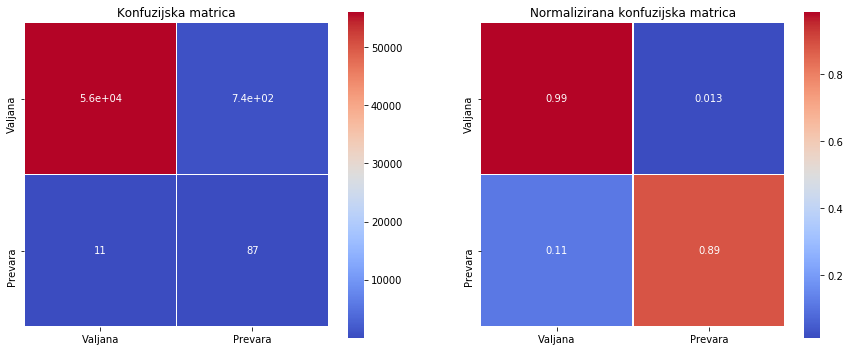

----------------------------------------------------------------------------------------------------


In [56]:
full_pred_knn_params = knn_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_knn_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Nakon podešavanja parametara dobili smo zanimljive rezultate. Odnosno, preciznost (10.55%) i f1-mjera su jako porasle (18.85%), a osjetljivost se malo smanjila (88.78%) u odnosu na model treniran bez parametara. Kada pogledamo matricu konfuzije vidimo da je broj pogrešno klasificiranih valjanih transakcija pao sa ~1200 na ~740 (najmanje dosad), ali se i smanjio broj ispravno klasificiranih prevara (bilo je 88, sad je 87).

## Metoda porpornih vektora

In [57]:
svc_usample = SVC()
svc_usample.fit(X_usample_train, y_usample_train)
svc_training_score_usample = cross_val_score(svc_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: " + 
      str(round(svc_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: 93.19%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.67%
	Recall score: 88.78%
	F1 score: 17.43%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


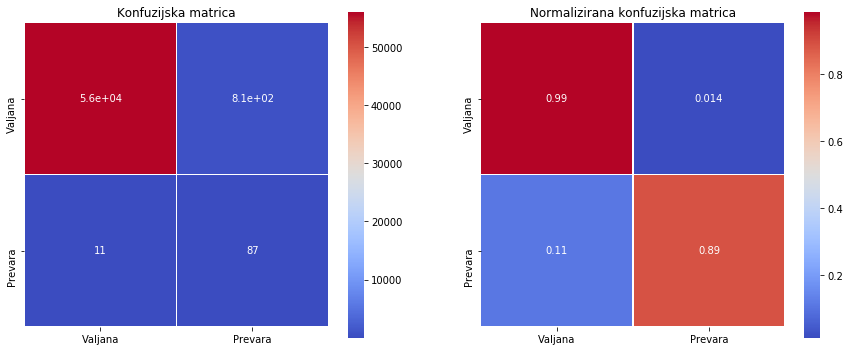

----------------------------------------------------------------------------------------------------


In [58]:
full_pred_svc = svc_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_svc, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Testiranjem na ovom modelu vidimo da smo dobili dosad najbolju (ako gledamo modele bez podešenih parametara) preciznost (9.67%) i f1-mjeru (17.43%), dok je osjetljivost 88.78%. Iz konfuzijske matrice vidimo da je model ispravno klasificirao 87 prevara (što je najmanje dosad), ali je također pogrešno klasificirao svega oko 810 valjanih transakcija (prvi koji ima manje od 1000).
<br> Pokušat ćemo pažljivo podesiti parametre pa vidjeti hoće li to dodatno popraviti rezultate.

Parametri koje podešavamo za metodu potpornih vektora:
<ul>
    <li><em>C</em> - regularizacijski parametar, ima istu ulogu kao i u logističkoj regresiji</li>
    <li><em>kernel</em> - određuje funkciju koja omogućava rad u više-dimenzionalnom prostoru bez da ikad izračuna koordinate u tom višedimenzionalnom prostoru, već koristi unutarnje produkte slika svih parova podataka u prostoru značajki
        <ul>
            <li><i>linear</i> - koristi linearnu plohu da podijeli podatke, formula: $K(X,Y) = X^TY$</li>
            <li><i>poly</i> - koristi polinom da podijeli podatke, formula: $K(X,Y) = (\gamma \cdot X^TY + r)^d$</li>
            <li><i>sigmoid</i> - koristi sigmoidalnu funkciju da podijeli podatke, formula: $K(X,Y) = \tanh(\gamma \cdot X^TY + r)$</li>
            <li><i>rbf</i> -  koristi krivulje koje okružuju podatke i sumira ih tako da granica podjele bude definirana topološkim uvjetom, formula: $K(X,Y) = \exp \bigg( \frac{\mid \mid X - Y\mid \mid^2}{2\sigma^2} \bigg)$</li>
        </ul>
    <li><em>stupanj</em> (u formuli za <i>poly</i> označen s d) - određuje stupanj polinoma</li>
    <li><em>gamma</em> (u formulama za <i>poly</i> i <i>sigmoid</i> označen s $\gamma$) - određuje koeficijent</li>
</ul>

In [59]:
svc_c_params = [0.001, 0.01, 0.1, 1, 10, 1]
kernel_params = ['linear', 'poly', 'sigmoid', 'rbf']
degree_params = [1, 2, 3, 4, 5]
gamma_params = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
#class_weight_params = [None, 'balanced']


svc_params = {'C': svc_c_params, 'kernel': kernel_params, 'degree': degree_params, 'gamma': gamma_params } #,
              #'class_weight': class_weight_params}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_usample_train, y_usample_train)
svc_params_usample = grid_svc.best_estimator_
svc_params_best = grid_svc.best_params_
print('Najbolji parametri: ' + str(svc_params_best))

svc_training_score_params_usample = cross_val_score(svc_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(svc_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.001, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): 94.04%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.85%
	Recall score: 89.8%
	F1 score: 17.76%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.90      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


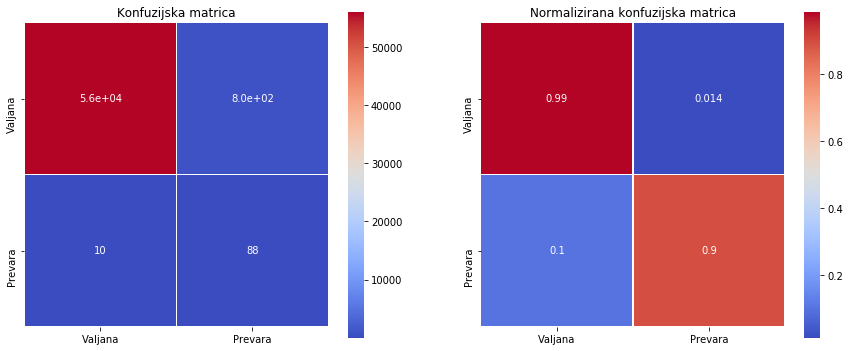

----------------------------------------------------------------------------------------------------


In [60]:
full_pred_svc_params = svc_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_svc_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Podešavanje parametara je napravilo dosta za ovaj model. I preciznost (9.85%), i f1-mjera (17.76%), i osjetljivost (89.8%) su porasli. Nijedan od tih skokova nije velik, ali je ipak u sve tri kateogrije. Iz matrice konfuzije vidimo da imamo 88 ispravno klasificiranih prevara (bilo je 87), te ~800 pogrešno klasificiranih valjanih transakcija (bilo je ~800). 

## Boosting

Za boosting ćemo koristiti 4 različita algoritma te usporediti njihove rezultate. Algoritmi koje koristimo su:
<ol>
    <li>XGB (eXtreme Gradient Boosting)</li>
    <li>LGBM (Light Gradient Boosting Method)</li>
    <li>CatBoost (CATegorical Boosting)</li>
    <li>AdaBoost (ADAptive Boosting)</li>
</ol>

In [65]:
print("XGB (eXtreme Gradient Boosting)")
xgb_usample = XGBClassifier()
xgb_usample.fit(X_usample_train, y_usample_train)
xgb_usample_training_score = cross_val_score(xgb_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: " + 
       str(round(xgb_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
lgbm_usample = LGBMClassifier()
lgbm_usample.fit(X_usample_train, y_usample_train)
lgbm_usample_training_score = cross_val_score(lgbm_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: " + 
       str(round(lgbm_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("CatBoost (CATegorical Boosting)")
cat_usample = CatBoostClassifier(silent=True)
cat_usample.fit(X_usample_train, y_usample_train)
cat_usample_training_score = cross_val_score(cat_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: " + 
       str(round(cat_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("AdaBoost (ADAptive Boosting)")
ada_usample = AdaBoostClassifier()
ada_usample.fit(X_usample_train, y_usample_train)
ada_usample_training_score = cross_val_score(ada_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: " + 
       str(round(ada_usample_training_score.mean(), 4) * 100) + '%')

XGB (eXtreme Gradient Boosting)
Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: 92.94%
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: 93.28%
----------------------------------------------------------------------------------------------------
CatBoost (CATegorical Boosting)
Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: 93.65%
----------------------------------------------------------------------------------------------------
AdaBoost (ADAptive Boosting)
Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: 92.01%


****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.54%
	Recall score: 92.86%
	F1 score: 10.45%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


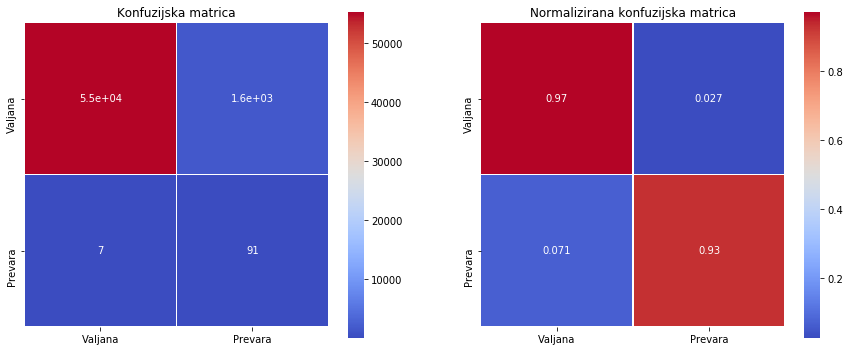

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.7%
	Recall score: 91.84%
	F1 score: 10.73%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


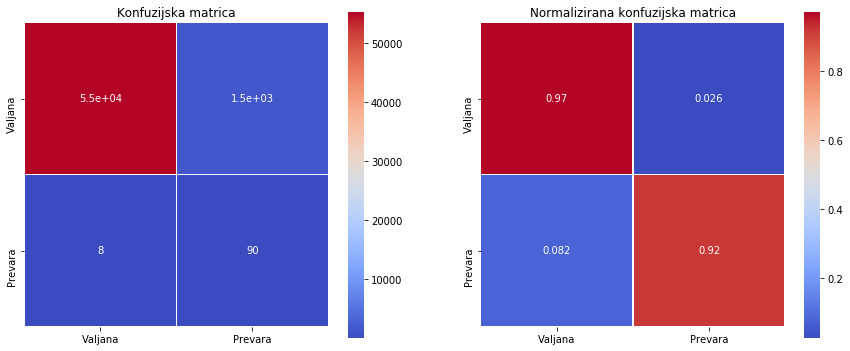

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.290000000000001%
	Recall score: 91.84%
	F1 score: 15.22%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.92      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


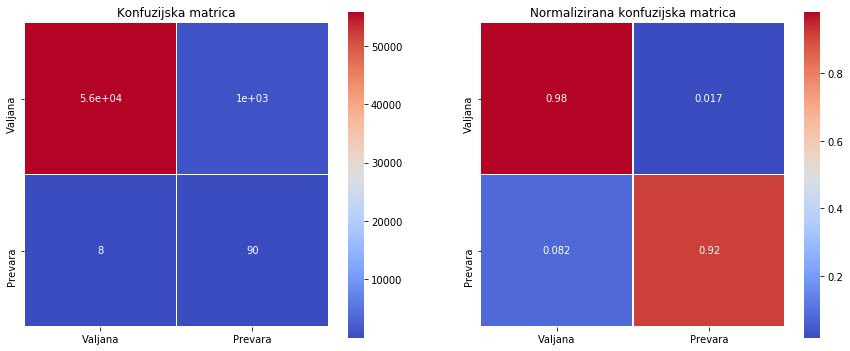

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.86%
	Recall score: 91.84%
	F1 score: 5.55%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


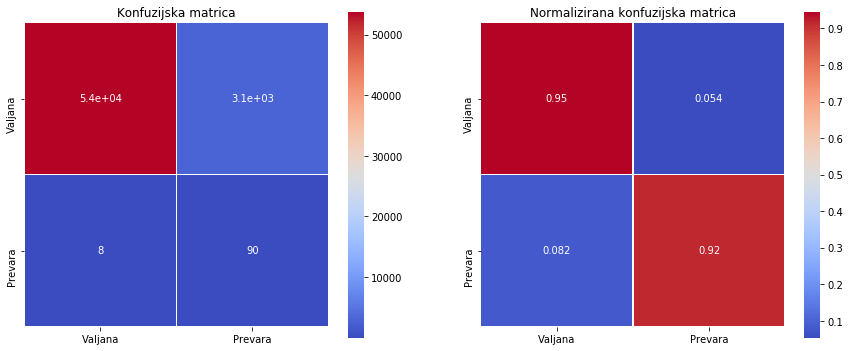

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [66]:
full_pred_xgb = xgb_usample.predict(X_data_test)
full_pred_lgbm = lgbm_usample.predict(X_data_test)
full_pred_cat = cat_usample.predict(X_data_test)
full_pred_ada = ada_usample.predict(X_data_test)

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
print_everything(y_data_test, full_pred_lgbm, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Prokomentirajmo sada rezultate. <br>
<ol>
    <li><em>XGB</em>
        <p>Koristeći XGB dobili smo jako dobre rezultate testiranja. Preciznost je 5.54%, f1-mjera 10.45%, a osjetljivost je vrlo visokih 92.86%. Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1600 valjanih transakcija (što je bolje od većine algoritama dosad), dok je ispravno klasificirano čak 91 prevara (što je najviše dosad).</p>
    </li><br><hr>
    <li><em>LGBM</em>
        <p>Korištenjem LGBM-a smo također dobili jako dobre rezultate. Preciznost (5.7%) i f1-mjera(10.73%) su malo viši nego kod XGB-a, dok je osjetljivost (91.84%) malo niža. Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1500 valjanih transakcija (stotinjak manje nego kod XGB-a), dok je ispravno klasificirano 90 prevara (jedna manje nego kod XGB-a).</p>
    </li><br><hr>
    <li><em>CatBoost</em>
        <p>Sljedeći algoritam boostinga je CatBoost. Njime smo dobili još bolje rezultate nego LGBM-om. Tako je u ovom slučaju preciznost čak 8.29%, a f1-mjera 15.22%, dok je osjetljivost 91.84% (isto kao i kod LGBM-a). Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1000 valjanih transakcija (petstotinjak manje nego kod LGBM-a, odnosno trećina manje), dok je ispravno klasificirano 90 prevara (isto kao i kod LGBM-a). </p>
    </li><br><hr>
    <li><em>AdaBoost</em>
        <p>Posljednji algoritam boostinga koji koristimo je AdaBoost. On se pokazao kao najslabiji od boosting algoritama. U ovom slučaju preciznost samo 2.86%, a f1-mjera 5.55%, dok je osjetljivost 91.84% (isto kao i kod LGBM-a, te CatBoosta). Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 3100 valjanih transakcija (triput više nego kod CatBoosta), dok je ispravno klasificirano 90 prevara (isto kao i kod CatBoosta). </p>
    </li>
    
    
</ol>
<br> <hr>
Sada ćemo za sva 4 boosting algoritma podesiti parametre te vidjeti kako će to utjecati na rezultate.


Parametri koje podešavamo kod XGB-a:
<ul>
    <li><em>gamma</em> - regularizacijski parametar 'kroz sva stabla'</li>
    <li><em>maksimalna dubina</em> - maksimalna dubina svakog stabla</li>
    <li><em>udio stupaca po stablu</em> - udio značajki koje upotrebljavamo za konstrukciju svakog novog stabla</li>
    <li><em>stopa učenja</em> - određuje koliko koraka treba napraviti (što je stopa manja, imamo više koraka, odnosno sporije učenje, ali možda i precizniji model)</li>
    <li><em>broj procjenitelja</em> - broj stabala koji koristimo prilikom treniranja</li>
</ul>

In [67]:
xgb_gamma = [0, 1, 5, 10]
xgb_max_depth = [1, 2, 3, 4, 5, 7]
xgb_colsample_bytree = [0.3, 0.5, 0.8]
xgb_learning_rate = [0.3, 0.1, 0.05, 0.01]
xgb_n_estimators = [10, 20, 50, 100]
xgb_params = {'gamma': xgb_gamma, 'max_depth': xgb_max_depth, 'colsample_bytree': xgb_colsample_bytree, 
              'learning_rate': xgb_learning_rate, 'n_estimators': xgb_n_estimators}

grid_xgb = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb.fit(X_usample_train, y_usample_train)
xgb_params_usample = grid_xgb.best_estimator_
xgb_params_best = grid_xgb.best_params_

Parametri koje podešavamo kod LGBM-a:
<ul>
    <li><em>tip boostinga</em> - određuje koji od sljedećih algoritama koristimo za boosting
        <ul>
            <li><i>gdbt (Gradient Boosting Decision Tree)</i> - tradicionalna stabla odluke trenirana u nekom određenom  redoslijedu (u svakom koraku model pokušava naučiti razliku između stvarnog izlaza i težinske sume predikcija prethodne iteracije)</li>
            <li><i>goss (Gradient-based One Sided Sampling)</i> -  metoda koja se zasniva na odbacivanju instanci s malim gradijentom (jer su te već dobro trenirane), te se fokusira samo na one s većim gradijentom</li>
            <li><i>rf (Random Forest)</i> - klasičan pristup korištenjem slučajnih šuma</li>
            <li><i>dart (Dropouts meets multiple Additive Regression Trees)</i> - novija metoda u koju je dropout tehnika korištena najviše kod dubokih neuronskih mreža</li>
        </ul>
    </li>
    <li><em>maksimalna dubina</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>udio stupaca po stablu</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>stopa učenja</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - ima isto značenje kao i kod XGB-a</li>
</ul>

In [68]:
lgbm_boosting_type = ['gbdt', 'goss', 'rf', 'dart']
lgbm_max_depth = xgb_max_depth
lgbm_learning_rate = xgb_learning_rate
lgbm_colsample_bytree = xgb_colsample_bytree
lgbm_n_estimators = xgb_n_estimators
lgbm_params = {'boosting_type': lgbm_boosting_type, 'max_depth': lgbm_max_depth, 'colsample_bytree': lgbm_colsample_bytree, 
               'learning_rate': lgbm_learning_rate, 'n_estimators': lgbm_n_estimators}

grid_lgbm = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm.fit(X_usample_train, y_usample_train)
lgbm_params_usample = grid_lgbm.best_estimator_
lgbm_params_best = grid_lgbm.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

Parametri koje podešavamo kod CatBoosta:
<ul>
    <li><em>dubina</em> - isto značenje kao i kod XGB-a</li>
    <li><em>stopa učenja</em> - isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - isto značenje kao i kod XGB-a</li>
</ul>

In [69]:
cat_depth = xgb_max_depth
cat_learning_rate = xgb_learning_rate
cat_n_estimators = xgb_n_estimators
cat_params = {'depth': cat_depth, 'learning_rate': cat_learning_rate, 'n_estimators': cat_n_estimators }

grid_cat = GridSearchCV(CatBoostClassifier(silent=True), cat_params)
grid_cat.fit(X_usample_train, y_usample_train)
cat_params_usample = grid_cat.best_estimator_
cat_params_best = grid_cat.best_params_


Parametri koje podešavamo kod AdaBoosta:
<ul>
    <li><em>procjenitelj</em> - procjenitelj kojeg AdaBoost koristi (u našem slučaju stablo odluke)
        <ul>
            <li><i>kriterij</i> - ima isto značenje kao i za stablo odluke</li>
            <li><i>splitter</i> - ima isto značenje kao i za stablo odluke</li>
            <li><i>maksimalna dubina</i> - ima isto značenje kao i za stablo odluke</li>
        </ul>
    </li>
    <li><em>stopa učenja</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - ima isto značenje kao i kod XGB-a</li>
</ul>

In [70]:
ada_criterion = ['gini', 'entropy']
ada_max_depth = xgb_max_depth
ada_splitter = ['best', 'random']
ada_n_estimators = xgb_n_estimators
ada_learning_rate = xgb_learning_rate
ada_params = {'n_estimators': ada_n_estimators, 'learning_rate': ada_learning_rate}

ada_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth": xgb_max_depth,
              "n_estimators": xgb_n_estimators,
              "learning_rate": xgb_learning_rate
             }

grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada.fit(X_usample_train, y_usample_train)
ada_params_usample = grid_ada.best_estimator_
ada_params_best = grid_ada.best_params_

In [71]:
xgb_training_score_params_usample = cross_val_score(xgb_params_usample, X_usample_train, y_usample_train, cv=rskf)
lgbm_training_score_params_usample = cross_val_score(lgbm_params_usample, X_usample_train, y_usample_train, cv=rskf)
cat_training_score_params_usample = cross_val_score(cat_params_usample, X_usample_train, y_usample_train, cv=rskf)
ada_training_score_params_usample = cross_val_score(ada_params_usample, X_usample_train, y_usample_train, cv=rskf)

print('Treniranje (sa parametrima)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_best))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_best))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_best))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_best))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample.mean(), 4) * 100) + '%')


Treniranje (sa parametrima)
----------------------------------------------------------------------------------------------------
XGB
Najbolji parametri: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Rezultat treniranja: 93.32000000000001%
----------------------------------------------------------------------------------------------------
LGBM
Najbolji parametri: {'boosting_type': 'goss', 'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Rezultat treniranja: 93.66%
----------------------------------------------------------------------------------------------------
CatBoost
Najbolji parametri: {'depth': 5, 'learning_rate': 0.05, 'n_estimators': 100}
Rezultat treniranja: 93.74%
----------------------------------------------------------------------------------------------------
AdaBoost
Najbolji parametri: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 4, 'base_estimator__splitter':

****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.2299999999999995%
	Recall score: 93.88%
	F1 score: 9.91%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.94      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


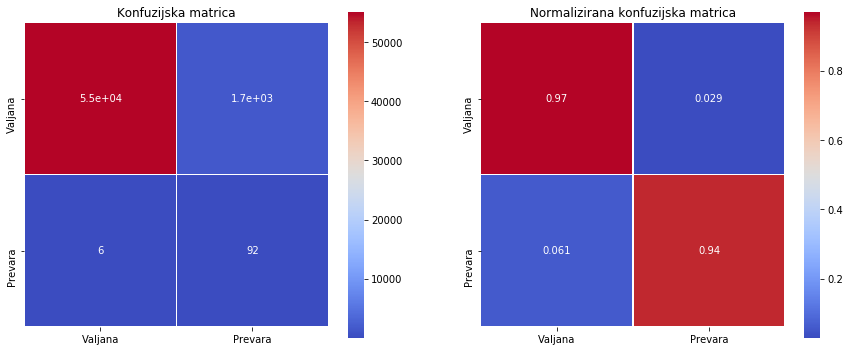

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.9399999999999995%
	Recall score: 92.86%
	F1 score: 14.63%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.93      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.96      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


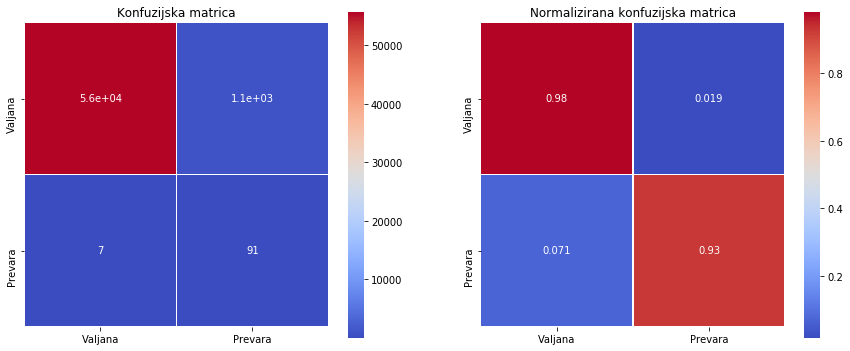

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.13%
	Recall score: 90.82000000000001%
	F1 score: 16.59%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


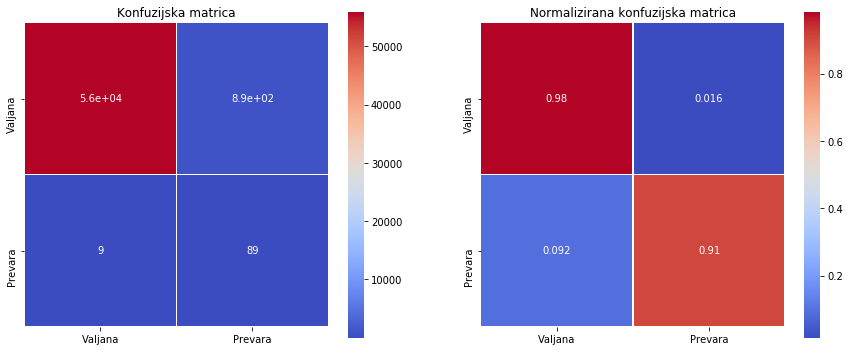

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.790000000000001%
	Recall score: 90.82000000000001%
	F1 score: 16.02%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


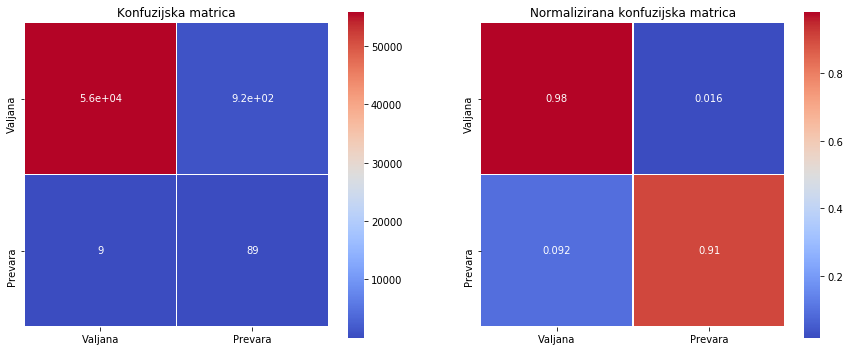

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [72]:
full_pred_xgb_params = xgb_params_usample.predict(X_data_test)
full_pred_lgbm_params = lgbm_params_usample.predict(X_data_test)
full_pred_cat_params = cat_params_usample.predict(X_data_test)
full_pred_ada_params = ada_params_usample.predict(X_data_test)

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
print_everything(y_data_test, full_pred_lgbm_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Prokomentirajmo sada rezultate. <br>
<ol>
    <li><em>XGB</em>
        <p>Nakon podešavanja parametara XGB je ponovno imao dobre rezultate. Preciznost (5.23%) i f1-mjera (9.91%) su se malo smanjile u odnosu na model bez parametara, no zato je osjetljivost porasla (sada je 93.88%). Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao čak 92 prevare, dok je pogrešno klasificirao oko 1700 valjanih transakcija. U odnosu na model bez parametara sada imamo 1 ispravno klasificiranu prevaru više, te stotinjak pogrešno klasificiranih valjanih transakcija više. </p>
    </li><br><hr>
    <li><em>LGBM</em>
        <p>Podešavanjem parametara kod LGBM-a smo dobili vidljivo bolje rezultate. I preciznost (7.94%) i f1-mjera (14.63%) su se poboljšale, no zanimljivo je da je i osjetljivost (92.86%) porasla. Iz matrice konfuzije vidimo da sada imamo 91 ispravno klasificiranu prevaru (bez parametara je bilo 90) te svega oko 1100 pogrešno klasificiranih valjanih transakcija (bez parametara je bilo oko 1500). Znači model je bolji od onog bez parametara u svim kategorijama.</p>
    </li><br><hr>
    <li><em>CatBoost</em>
        <p> Kod CatBoosta smo dobili solidne rezultate. I ovdje su i preciznost (9.13%) i f1-mjera (16.59%) porasle, no osjetljivost (90.82%) je malo pala. Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao 89 prevara (jednu manje u odnosu na model bez parametara), ali je pogrešno klasificirao samo ~890 valjanih transakcija (oko 110 manje nego bez parametara). </p>
    </li><br><hr>
    <li><em>AdaBoost</em>
        <p>Adaboost je algoritam koji se podeašavanjem parametara najznačajnije popravio. I preciznost (8.79%) i f1-mjera (16.02%) su jako skočile (preciznost je bila 2.86%, a f1-mjera 5.55%). Osjetljivost je doduše blago pala i sad je 90.82%. Iz matrice konfuzije vidimo da je model ispravno klasificirao 89 prevara (samo jednu manje nego model bez parametara), dok je pogrešno klasificirao svega ~920 valjanih transakcija (bilo je čak ~3100). </p>
    </li> 
</ol>



## Metoda klasifikcije glasanjem

Zadnji klasifikator koji ćemo koristiti je klasifikacija glasanjem. Promatrat ćemo 11 različitih klasifikatora.
<ol>
    <li><em>Prvi glasački klasifikator (1)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Drugi glasački klasifikator (2)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
        </ul>
    </li> <hr>
    <li><em>Treći glasački klasifikator (3)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
            <li>Metoda najbližih susjeda
        </ul>
    </li> <hr>
    <li><em>Četvrti glasački klasifikator (4)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>LGBM</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Peti glasački klasifikator (5)</em> - glasači: 
        <ul>
            <li>LGBM</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Šesti glasački klasifikator (6)</em> - glasači: 
        <ul>
            <li>Bagging</li>
            <li>Stabla odluke</li>
        </ul>
    </li> <hr>
    <li><em>Sedmi glasački klasifikator (7)</em> - glasači: 
        <ul>
            <li>Bagging</li>
            <li>Metoda najbližih susjeda</li>
        </ul>
    </li> <hr>
    <li><em>Osmi glasački klasifikator (8)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda najbližih susjeda</li>
        </ul>
    </li> <hr>
    <li><em>Deveti glasački klasifikator (9)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda najbližih susjeda</li>
            <li>CatBoost</li>
        </ul>
    </li> <hr>
    <li><em>Deseti glasački klasifikator (10)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
            <li>AdaBoost</li>
        </ul>
    </li> <hr>
    <li><em>Jedanaesti glasački klasifikator (11)</em> - glasači: 
        <ul>
            <li>XGB</li>
            <li>LGBM</li>
            <li>CatBoost</li>
            <li>AdaBoost</li>
        </ul>
    </li>
</ol>

In [73]:
print('(1) = logistička regresija, xgb, random forest')
print('(2) = logistička regresija, xgb, random forest, metoda potpornih vektora')
print('(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(4) = logistička regresija, lgbm, random forest')
print('(5) = lgbm, random forest')
print('(6) = bagging, decision trees')
print('(7) = bagging, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(8) = random forest, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(9) = random forest, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda, catboost')
print('(10) = random forest, metoda potpornih vektora, adaboost')
print('(11) = xgb, lgbm, catboost, adaboost')
print('-'*100)

voting1_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample)
])
voting1_usample.fit(X_usample_train, y_usample_train)
voting1_usample_training_score = cross_val_score(voting1_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: " + 
      str(round(voting1_usample_training_score.mean(), 4) * 100) + '%')


voting2_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample)
])
voting2_usample.fit(X_usample_train, y_usample_train)
voting2_usample_training_score = cross_val_score(voting2_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: " + 
      str(round(voting2_usample_training_score.mean(), 4) * 100) + '%')

voting3_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample), ('knn', knn_params_usample)
])
voting3_usample.fit(X_usample_train, y_usample_train)
voting3_usample_training_score = cross_val_score(voting3_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: " + 
      str(round(voting3_usample_training_score.mean(), 4) * 100) + '%')

voting4_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting4_usample.fit(X_usample_train, y_usample_train)
voting4_usample_training_score = cross_val_score(voting4_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: " + 
      str(round(voting4_usample_training_score.mean(), 4) * 100) + '%')

voting5_usample = VotingClassifier(estimators=[ ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting5_usample.fit(X_usample_train, y_usample_train)
voting5_usample_training_score = cross_val_score(voting5_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (5) nad undersampliranim datasetom: " + 
      str(round(voting5_usample_training_score.mean(), 4) * 100) + '%')


voting6_usample = VotingClassifier(estimators=[
    ('bag', bag_params_usample), ('dt', dt_params_usample)
])
voting6_usample.fit(X_usample_train, y_usample_train)
voting6_usample_training_score = cross_val_score(voting6_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (6) nad undersampliranim datasetom: " + 
      str(round(voting6_usample_training_score.mean(), 4) * 100) + '%')

voting7_usample = VotingClassifier(estimators=[
    ('bag', bag_params_usample), ('knn', knn_params_usample), 
])
voting7_usample.fit(X_usample_train, y_usample_train)
voting7_usample_training_score = cross_val_score(voting7_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (7) nad undersampliranim datasetom: " + 
      str(round(voting7_usample_training_score.mean(), 4) * 100) + '%')

voting8_usample = VotingClassifier(estimators=[
    ('rf', rf_params_usample), ('knn', knn_params_usample), 
])
voting8_usample.fit(X_usample_train, y_usample_train)
voting8_usample_training_score = cross_val_score(voting8_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (8) nad undersampliranim datasetom: " + 
      str(round(voting8_usample_training_score.mean(), 4) * 100) + '%')

voting9_usample = VotingClassifier(estimators=[
    ('rf', rf_params_usample), ('knn', knn_params_usample), ('cat', cat_params_usample) 
])
voting9_usample.fit(X_usample_train, y_usample_train)
voting9_usample_training_score = cross_val_score(voting9_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (9) nad undersampliranim datasetom: " + 
      str(round(voting9_usample_training_score.mean(), 4) * 100) + '%')

voting10_usample = VotingClassifier(estimators=[
    ('rf', rf_params_usample), ('svc', knn_params_usample), ('ada', ada_params_usample) 
])
voting10_usample.fit(X_usample_train, y_usample_train)
voting10_usample_training_score = cross_val_score(voting10_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (10) nad undersampliranim datasetom: " + 
      str(round(voting10_usample_training_score.mean(), 4) * 100) + '%')

voting11_usample = VotingClassifier(estimators=[
    ('xgb', xgb_params_usample), ('lgbm', lgbm_params_usample), ('cat', cat_params_usample),
    ('ada', ada_params_usample)
])
voting11_usample.fit(X_usample_train, y_usample_train)
voting11_usample_training_score = cross_val_score(voting11_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (11) nad undersampliranim datasetom: " + 
      str(round(voting11_usample_training_score.mean(), 4) * 100) + '%')

(1) = logistička regresija, xgb, random forest
(2) = logistička regresija, xgb, random forest, metoda potpornih vektora
(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (2) najbližih susjeda
(4) = logistička regresija, lgbm, random forest
(5) = lgbm, random forest
(6) = bagging, decision trees
(7) = bagging, k (2) najbližih susjeda
(8) = random forest, k (2) najbližih susjeda
(9) = random forest, k (2) najbližih susjeda, catboost
(10) = random forest, metoda potpornih vektora, adaboost
(11) = xgb, lgbm, catboost, adaboost
----------------------------------------------------------------------------------------------------
Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: 93.91000000000001%
Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: 93.99%
Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: 94.28999999999999%
Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom:

****************************************************************************************************
Glasački klasifikator (1)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.58%
	Recall score: 90.82000000000001%
	F1 score: 15.68%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


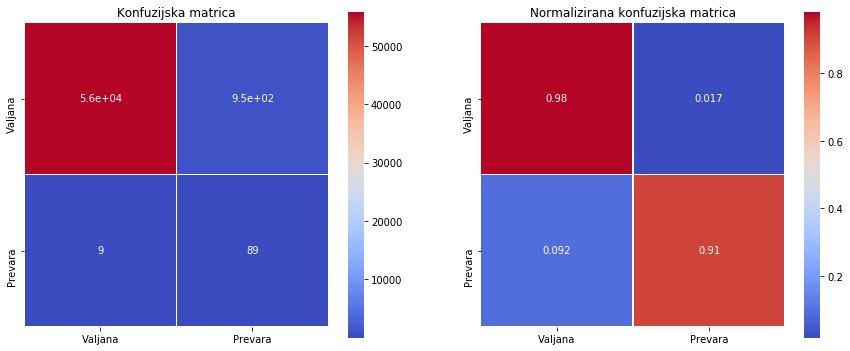

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (2)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.809999999999999%
	Recall score: 90.82000000000001%
	F1 score: 22.45%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.91      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


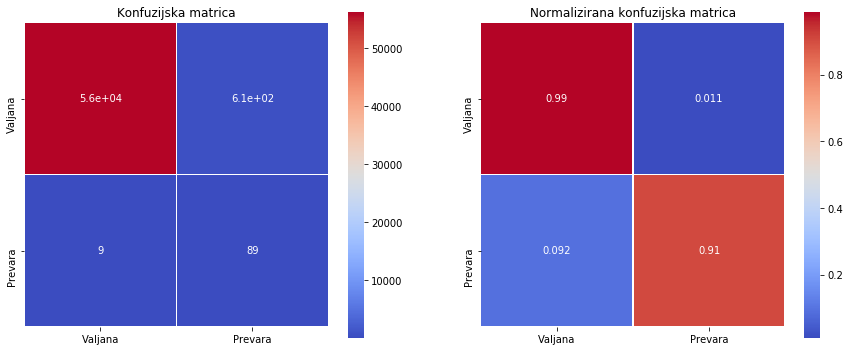

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (3)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 10.6%
	Recall score: 89.8%
	F1 score: 18.970000000000002%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.90      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


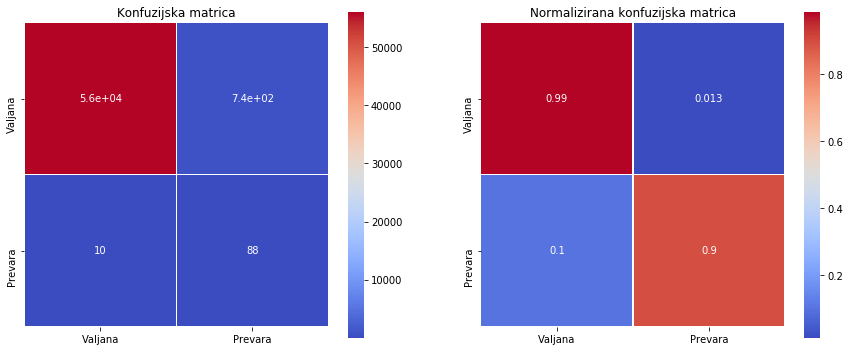

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (4)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.709999999999999%
	Recall score: 90.82000000000001%
	F1 score: 15.89%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


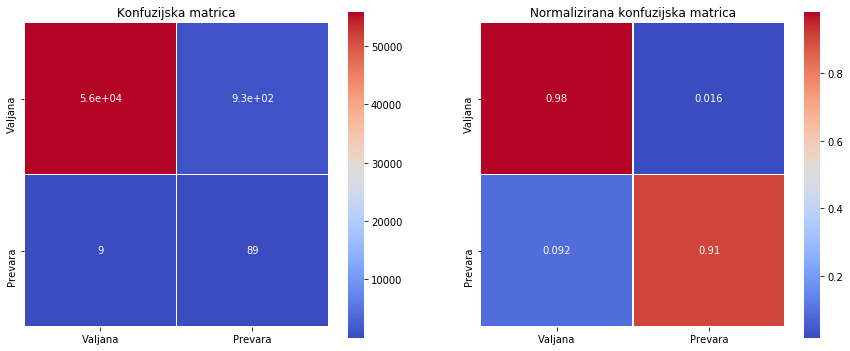

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [74]:
full_pred_voting1_params = voting1_usample.predict(X_data_test)
full_pred_voting2_params = voting2_usample.predict(X_data_test)
full_pred_voting3_params = voting3_usample.predict(X_data_test)
full_pred_voting4_params = voting4_usample.predict(X_data_test)

print('*'*100)
print('Glasački klasifikator (1)')
print_everything(y_data_test, full_pred_voting1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (2)")
print_everything(y_data_test, full_pred_voting2_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (3)")
print_everything(y_data_test, full_pred_voting3_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (4)")
print_everything(y_data_test, full_pred_voting4_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Komentari za prva 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Prvi glasački klasifikator (1)</em> - solidan klasifikator sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 8.58%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 15.68%</li>
            <li><i>ispravno klasificirane prevare</i>: 89</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~950</li>
        </ul>
    </li>
    <li><em>Drugi glasački klasifikator (2)</em> - dosta bolji od prvog klasifikatora sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 12.81%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 22.45%</li>
            <li><i>ispravno klasificirane prevare</i>: 89 (jednako kao i prvi)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~610 (~340 manje od prvog)</li>
        </ul>
    </li>
    <li><em>Treći glasački klasifikator (3)</em> - klasifikator u rangu prvog (očito lošiji od drugog) sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 10.6%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 18.97%</li>
            <li><i>ispravno klasificirane prevare</i>: 88 (jedna manje nego prethodna 2)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~740 (za ~210 bolje od prvog)</li>
        </ul>
    </li>
    <li><em>Četvrti glasački klasifikator (4)</em> - dosad drugi najbolji klasifikator (bolji od (1) i (3)) sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 8.71%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 15.89%</li>
            <li><i>ispravno klasificirane prevare</i>: 89</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~930 (~20 manje od prvog)</li>
        </ul>
    </li>
</ul>

****************************************************************************************************
Glasački klasifikator (5)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 13.170000000000002%
	Recall score: 89.8%
	F1 score: 22.98%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


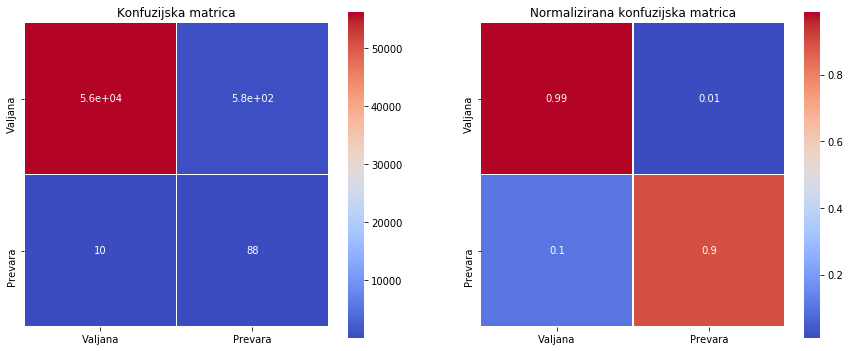

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (6)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 14.499999999999998%
	Recall score: 88.78%
	F1 score: 24.93%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.89      0.25        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


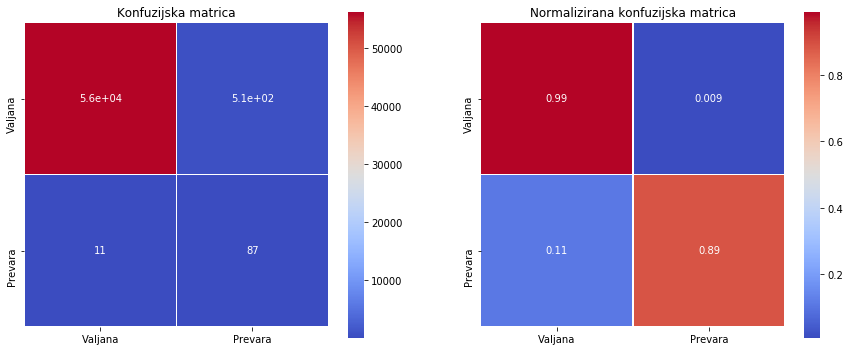

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (7)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 22.189999999999998%
	Recall score: 88.78%
	F1 score: 35.510000000000005%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.89      0.36        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962


----------------------------------------------------------------------------------------------------


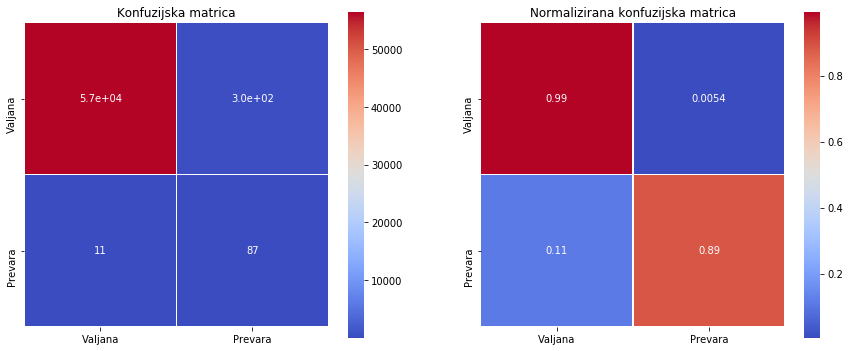

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (8)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 22.48%
	Recall score: 88.78%
	F1 score: 35.88%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.89      0.36        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962


----------------------------------------------------------------------------------------------------


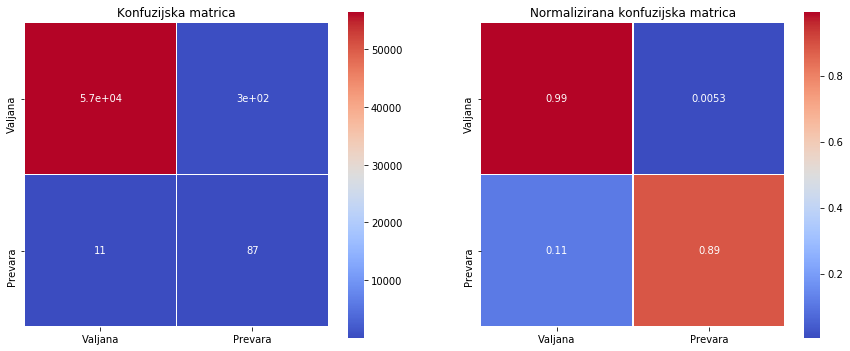

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [75]:
full_pred_voting5_params = voting5_usample.predict(X_data_test)
full_pred_voting6_params = voting6_usample.predict(X_data_test)
full_pred_voting7_params = voting7_usample.predict(X_data_test)
full_pred_voting8_params = voting8_usample.predict(X_data_test)

print('*'*100)
print('Glasački klasifikator (5)')
print_everything(y_data_test, full_pred_voting5_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (6)")
print_everything(y_data_test, full_pred_voting6_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (7)")
print_everything(y_data_test, full_pred_voting7_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (8)")
print_everything(y_data_test, full_pred_voting8_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Komentari za druga 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Peti glasački klasifikator (5)</em> - vrlo dobar klasifikator (malo lošiji od (2), ali bolji od ostalih):
        <ul>
            <li><i>preciznost</i>: 13.17%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 22.98%</li>
            <li><i>ispravno klasificirane prevare</i>: 88</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~580</li>
        </ul>
    </li>
    <li><em>Šesti glasački klasifikator (6)</em> - također vrlo dobar klasifikator (u rangu s prethodnim):
        <ul>
            <li><i>preciznost</i>: 14.45%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 24.93%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (najmanje od svih dosad)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~510 (također najmanje dosad)</li>
        </ul>
    </li>
    <li><em>Sedmi glasački klasifikator (7)</em> - ovo je već fantastičan klasifikator sa značajnije boljim rezultatima od prethodnog:
        <ul>
            <li><i>preciznost</i>: 22.19%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 35.51%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (jednako kao i prethodni)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~300 (za ~210 bolje od prethodnog)</li>
        </ul>
    </li>
    <li><em>Osmi glasački klasifikator (8)</em> - ovaj klasifikator je čak i malo bolji od prethodnog
        <ul>
            <li><i>preciznost</i>: 22.48% (0.29% bolje od prethodnog)</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 35.88% (0.37% bolje od prethodnog)</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (jednako kao i prethodni)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~300 </li>
        </ul>
    </li>
</ul>

****************************************************************************************************
Glasački klasifikator (9)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.139999999999999%
	Recall score: 89.8%
	F1 score: 21.39%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.90      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


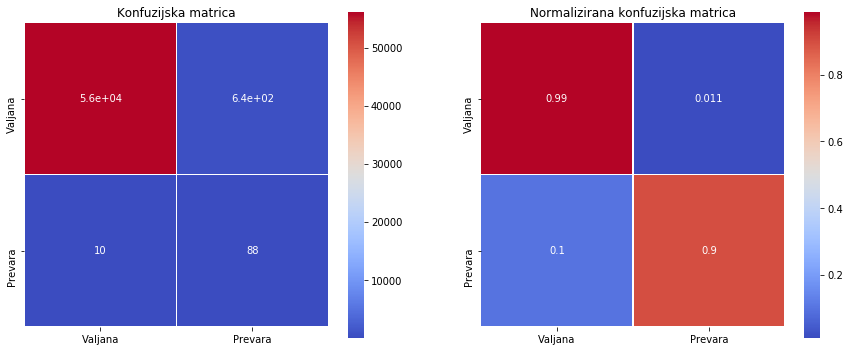

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (10)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.629999999999999%
	Recall score: 88.78%
	F1 score: 22.11%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.89      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


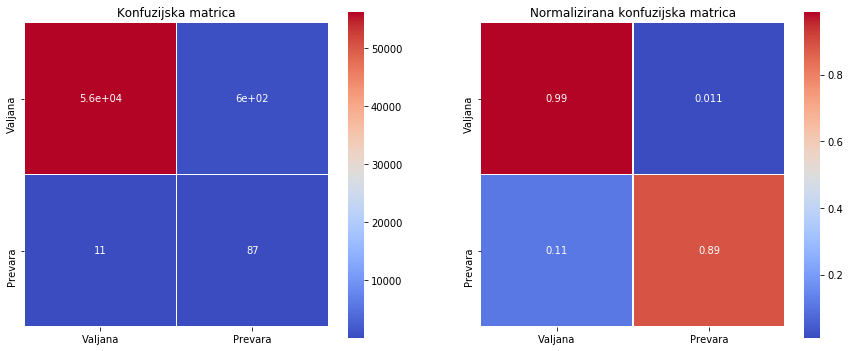

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (11)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 11.37%
	Recall score: 90.82000000000001%
	F1 score: 20.200000000000003%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.91      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.60     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


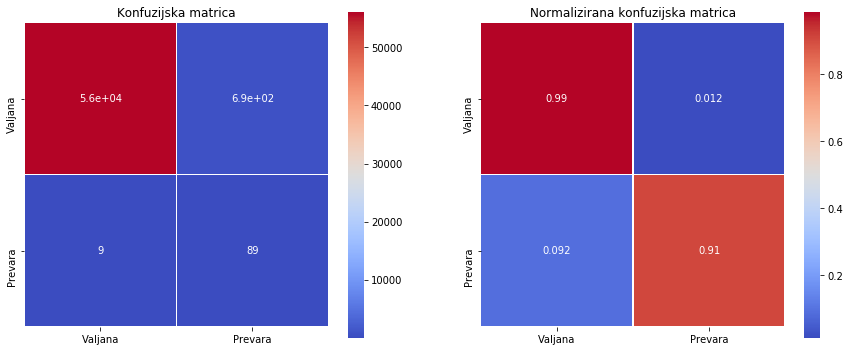

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [76]:
full_pred_voting9_params = voting9_usample.predict(X_data_test)
full_pred_voting10_params = voting10_usample.predict(X_data_test)
full_pred_voting11_params = voting11_usample.predict(X_data_test)

print('*'*100)
print('Glasački klasifikator (9)')
print_everything(y_data_test, full_pred_voting9_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (10)")
print_everything(y_data_test, full_pred_voting10_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (11)")
print_everything(y_data_test, full_pred_voting11_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Komentari za prva 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Deveti glasački klasifikator (9)</em> - poprilično dobar klasifikator sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 12.14%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 21.39%</li>
            <li><i>ispravno klasificirane prevare</i>: 88</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~640</li>
        </ul>
    </li>
    <li><em>Deseti glasački klasifikator (10)</em> - jedan od slabijih klasifikatora (u usporedbi sa ostalim glasačkim, i dalje nije loš):
        <ul>
            <li><i>preciznost</i>: 12.63%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 22.11%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 </li>
            <li><i>pogrešno klasificiryne valjane</i>: ~600 </li>
        </ul>
    </li>
    <li><em>Jedanaesti glasački klasifikator (11)</em> - klasifikator sa boljim prepoznavanjem prevara (najbolji od zadnja 3):
        <ul>
            <li><i>preciznost</i>: 11.37%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 20.2%</li>
            <li><i>ispravno klasificirane prevare</i>: 89 (jedan od boljih glasačkih)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~690 </li>
        </ul>
    </li>

</ul>